In [1]:
import gymnasium as gym
import gym_donkeycar

import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.distributions import Normal, Categorical

import torchvision
from torchvision import transforms

%matplotlib inline

In [2]:
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Preprocessing

""" transformation """
transform = transforms.Compose([
    transforms.ToTensor(), # -> scaled to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet normalization
    transforms.Lambda(lambda x: x.to(device)), # Move to device
    transforms.Resize((128, 128)),
    transforms.Grayscale(),
])

In [4]:
class ConvBlock(nn.Module):
    """ Use this block to change the number of channels. """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

    
class TransposeConvBlock(nn.Module):
    """ Use this block to change the number of channels and perform a deconvolution
        followed by batchnorm and a relu activation. """
    def __init__(self, in_channels, out_channels):
        super(TransposeConvBlock, self).__init__()
        
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.deconv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

    
class ResConvBlock(nn.Module):
    """ This block needs the same number input and output channels.
        It performs three convolutions with batchnorm, relu 
        and then adds a skip connection. """
    def __init__(self, in_channels, out_channels):
        super(ResConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        
        x = self.conv2(x)        
        x += residual
        x = self.relu(x)
        x = self.bn2(x)
        return x

    
class CategoricalStraightThrough(nn.Module):
    """
    Given a tensor of logits, this module samples from a categorical distribution,
    and computes the straight-through gradient estimator of the sampling operation.
    """
    def __init__(self, num_classes):
        super(CategoricalStraightThrough, self).__init__()
        self.num_classes = num_classes

    def forward(self, logits):
        
        # Compute the softmax probabilities
        probs = F.softmax(logits.view(-1, self.num_classes, self.num_classes), -1)

        # Sample from the categorical distribution
        m = Categorical(probs)
        sample = F.one_hot(m.sample(), num_classes=self.num_classes)

        # Compute the straight-through gradient estimator
        grad = probs - probs.detach()
        sample = sample + grad
        
        return sample

In [66]:
num_categories = logits.shape[-1]
num_categories

32

In [71]:
probs = F.softmax(logits, dim=-1)

In [72]:
probs[0,0].sum()

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [75]:
prior = torch.ones_like(probs) / num_categories
prior.shape

torch.Size([8, 32, 32])

In [79]:
num_categories = logits.shape[-1]
prior = torch.ones_like(probs) / num_categories
kl_loss = (probs * (torch.log(probs) - torch.log(prior))).sum()
kl_loss

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [129]:
class CategoricalVAE(nn.Module):
    def __init__(self, greyscale=True, beta=4.0, temperature=1.0):
        super(CategoricalVAE, self).__init__()

        if greyscale:
            self.input_channels = 1
        else:
            self.input_channels = 3
            
        self.beta = beta # kl-multiplier (from beta-VAE paper) => 51 for disentangled
        self.temperature = temperature
        
        self.encoder = nn.Sequential(
            ConvBlock(self.input_channels, 32),
            ResConvBlock(32, 32),
            ConvBlock(32, 32, kernel_size=4, padding=1, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(32, 64),
            ResConvBlock(64, 64),
            ConvBlock(64, 64, kernel_size=4, padding=1, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(64, 128),
            ResConvBlock(128, 128),
            ConvBlock(128, 128, kernel_size=4, padding=1, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(128, 256),
            ResConvBlock(256, 256),
            ConvBlock(256, 256, kernel_size=4, padding=1, stride=2), #nn.MaxPool2d(kernel_size=2, stride=2),
            
            ConvBlock(256, 512),
            ResConvBlock(512, 512),
            
            ConvBlock(512, 16),
            ResConvBlock(16, 16),
        )
        
        self.decoder = nn.Sequential(
            TransposeConvBlock(1, 1024),
            ResConvBlock(1024, 1024),
            
            TransposeConvBlock(1024, 512),
            ResConvBlock(512, 512),
            
            ConvBlock(512, 256),
            ResConvBlock(256, 256),
            
            ConvBlock(256, 128),
            ResConvBlock(128, 128),
            
            ConvBlock(128, 64),
            ResConvBlock(64, 64),
            
            ConvBlock(64, 16),
            nn.Conv2d(16, self.input_channels, kernel_size=3, padding=1, stride=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        logits = self.encoder(x).view(-1, 32, 32)
        return logits
    
    def decode(self, z):
        x = self.decoder(z.view(-1, 1, 32, 32))
        return x
    
    # def gumbel_softmax_sample(self, logits):
    #     gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits)))
    #     y = logits + gumbel_noise
    #     return F.softmax(y / self.temperature, dim=-1)
       
    def forward(self, x):
        # get gumble softmax logits
        logits = self.encode(x).view(-1, 32, 32)
        
        # sample and one-hot encode from hard gumbel softmax
        z = F.gumbel_softmax(logits, dim=-1, tau=self.temperature, hard=True) # uses straight-through gradients
        probs = F.softmax(logits, dim=-1) # needed for KL calculation
        
        # reconstruct x
        xhat = self.decode(z)
        
        return xhat, probs

    def get_loss(self, x, xhat, probs):
        
        # image reconstruction loss
        reconstruction_loss = F.mse_loss(x, xhat, reduction='mean')
        
        # kl-div to uniform categorical distribution
        #log_ratio = torch.log(probs * 32 + 1e-10) # log(Net(i) / Prior(i)) with uniform prior
        #kl_loss = torch.sum(probs * log_ratio, dim=-1)
        
        num_categories = logits.shape[-1]
        prior = torch.ones_like(probs) / num_categories
        kl_loss = (probs * (torch.log(probs) - torch.log(prior))).sum()
        
        # total loss
        loss = reconstruction_loss + self.beta * kl_loss
        
        return loss, reconstruction_loss, kl_loss

    def save_weights(self):
        if not os.path.exists("weights"):
            os.mkdir("weights")
        torch.save(self.state_dict(), "weights/VAE")
    
    def load_weights(self, path="weights/VAE", eval_mode=True):
        self.load_state_dict(torch.load(path))
        if eval_mode:
            print("Set VAE to evaluation mode.")
            self.eval()
        
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

batch_size = 4

vae = CategoricalVAE(
    greyscale=True,
    beta=1.0
).to(device)

vae_optim = optim.Adam(
    vae.parameters(), 
    lr=1e-2, 
    weight_decay=1e-5 # l2 regularization
)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

vae_scheduler = ReduceLROnPlateau(vae_optim, 'min')


print(vae.get_num_params())

38151857


In [100]:
batch_tensor_dummy = torch.rand(8, 1, 128, 128, device=device)

In [101]:
logits = vae.encode(batch_tensor_dummy)
print(logits.shape)

torch.Size([8, 32, 32])


In [131]:
""" overfit to one sample """
vae_losses, reconstruction_losses, kl_div_losses = [], [], []

for i in tqdm(range(10000)):
    
    xhat, probs = vae(batch_tensor)

    # get a loss and update the autoencoder
    vae_loss, reconstruction_loss, kl_div = vae.get_loss(batch_tensor, xhat, probs)
    vae_optim.zero_grad()
    vae_loss.backward()
    vae_optim.step()

    vae_losses.append(vae_loss.item())
    reconstruction_losses.append(reconstruction_loss.item())
    kl_div_losses.append(kl_div.item())

    if i % 100 == 0:
        print(f"loss: {vae_loss.item()}")

  0%|                                                                                         | 2/10000 [00:00<28:24,  5.86it/s]

loss: 2.858893871307373


  1%|▉                                                                                      | 102/10000 [00:16<25:45,  6.40it/s]

loss: 0.7965883612632751


  2%|█▊                                                                                     | 202/10000 [00:32<26:35,  6.14it/s]

loss: 0.7108838558197021


  3%|██▋                                                                                    | 302/10000 [00:48<26:29,  6.10it/s]

loss: 0.6947890520095825


  4%|███▍                                                                                   | 402/10000 [01:03<25:10,  6.35it/s]

loss: 0.6888567805290222


  5%|████▎                                                                                  | 502/10000 [01:19<26:12,  6.04it/s]

loss: 0.6863184571266174


  6%|█████▏                                                                                 | 602/10000 [01:35<25:25,  6.16it/s]

loss: 0.6851353645324707


  7%|██████                                                                                 | 702/10000 [01:52<24:56,  6.21it/s]

loss: 0.6844491958618164


  7%|██████▏                                                                                | 715/10000 [01:54<24:44,  6.25it/s]


KeyboardInterrupt: 

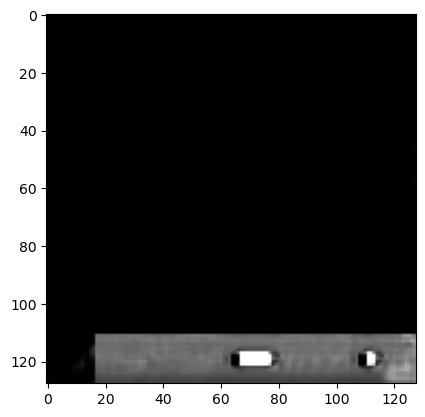

In [118]:
batch_tensor_dummy = torch.rand(8, 1, 128, 128, device=device)

with torch.no_grad():
    xhat, probs = vae(batch_tensor_dummy)
    plt.imshow(torch.permute(xhat[0].cpu(), (1,2,0)), cmap="gray")

In [9]:
""" vae training loop """

# create the environment
toy_env = False

if toy_env:
    env = gym.make("CarRacing-v2", render_mode="rgb_array")
else:
    exe_path = "/home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64"
    port = 9091
    config = {
        "exe_path" : exe_path, 
        "port" : port 
    }
    env = gym.make(
        "GymV21Environment-v0", 
        env_id="donkey-minimonaco-track-v0", # donkey-warehouse-v0 
        make_kwargs={
            "conf": config
        })

verbose = False
n_episodes = 10000
vae_losses, reconstruction_losses, kl_div_losses = [], [], []
vae.train()

for episode in tqdm(range(n_episodes)):
    
    # get the initial state
    obs, info = env.reset()
    
    # setup a minibatch of x's for training the autoencoder
    batch_counter = 0
    x = transform(obs)
    batch_tensor = torch.empty((batch_size,) + x.shape, device=device) # B,C,H,W
    
    # play one episode
    done = False
    while not done:
             
        # add the new x to the batch
        batch_tensor[batch_counter] = transform(obs)
        batch_counter += 1
        
        if batch_counter % batch_size == 0:
            # reset the batch counter
            batch_counter = 0
            
            # autoencoder forward pass with a minibatch
            xhat, probs = vae(batch_tensor)

            # get a loss and update the autoencoder
            vae_loss, reconstruction_loss, kl_div = vae.get_loss(batch_tensor, xhat, probs)
            vae_optim.zero_grad()
            vae_loss.backward()
            vae_optim.step()

            vae_losses.append(vae_loss.item())
            reconstruction_losses.append(reconstruction_loss.item())
            kl_div_losses.append(kl_div.item())
            
        # choose and execute an action
        action = env.action_space.sample()
        next_obs, reward, terminated, truncated, info = env.step(action)        
               
        done = terminated or truncated
        obs = next_obs
    
    if verbose and episode % 10 == 0: 
        print(f"train episode [{episode}/{n_episodes}] ===> Loss: {vae_loss.item():.3f}, ReconstructionLoss: {reconstruction_loss.item():.3f}, KL-Divergence: {kl_div.item():.3f}, lr: {get_lr(vae_optim)}")
        
env.close()

starting DonkeyGym env
Setting default: start_delay 5.0
Setting default: max_cte 8.0
Setting default: frame_skip 1
Setting default: cam_resolution (120, 160, 3)
Setting default: log_level 20
Setting default: host localhost
Setting default: steer_limit 1.0
Setting default: throttle_min 0.0
Setting default: throttle_max 1.0
donkey subprocess started
Found path: /home/till/Desktop/Thesis/donkeycar_sim/DonkeySimLinux/donkey_sim.x86_64


INFO:gym_donkeycar.core.client:connecting to localhost:9091 
/home/till/.local/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


loading scene mini_monaco


INFO:gym_donkeycar.envs.donkey_sim:on need car config
INFO:gym_donkeycar.envs.donkey_sim:sending car config.
INFO:gym_donkeycar.envs.donkey_sim:sim started!
  6%|█████▎                                                                              | 632/10000 [41:59<10:22:30,  3.99s/it]


KeyboardInterrupt: 

INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol N from STIXNonUnicode


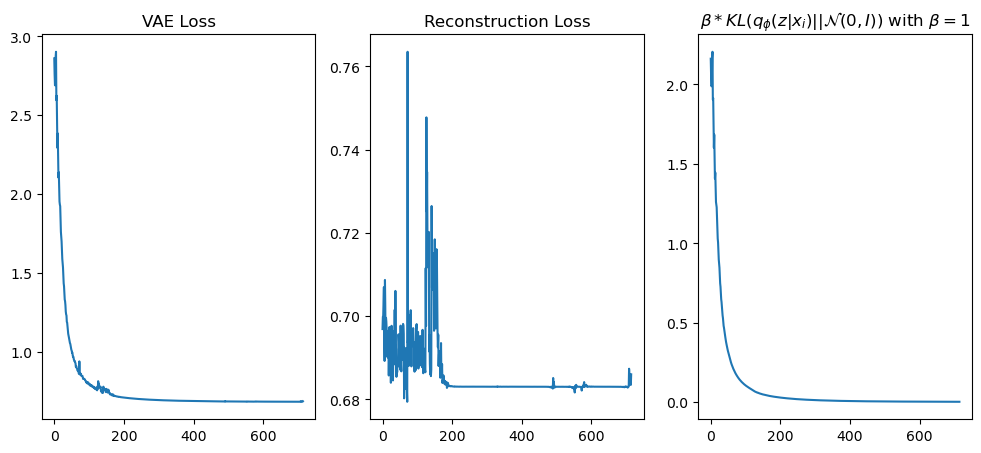

In [132]:
rolling_length = 1

fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

axs[0].set_title("VAE Loss")
vae_losses_moving_average = (
    np.convolve(
        np.array(vae_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(vae_losses_moving_average)), vae_losses_moving_average)


axs[1].set_title("Reconstruction Loss")
reconstruction_losses_moving_average = (
    np.convolve(
        np.array(reconstruction_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[1].plot(range(len(reconstruction_losses_moving_average)), reconstruction_losses_moving_average)

axs[2].set_title(r"$\beta * KL(q_\phi(z|x_i) || \mathcal{N}(0,I))$ with $\beta = %d$" %vae.beta)
kl_div_losses_moving_average = (
    np.convolve(
        np.array(kl_div_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[2].plot(range(len(kl_div_losses_moving_average)), kl_div_losses_moving_average);

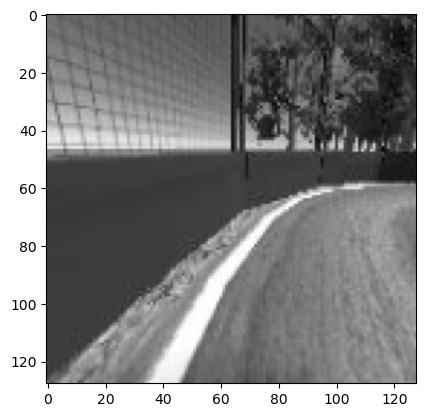

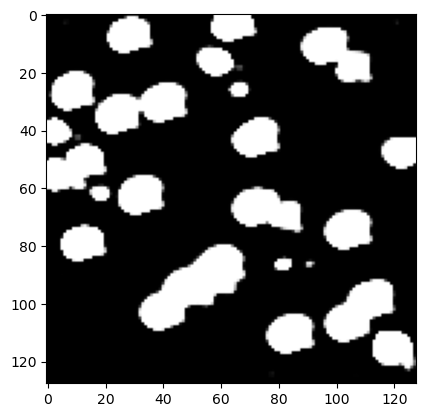

In [135]:
""" show the observation """
plt.imshow(torch.permute(batch_tensor[0].cpu(), (1,2,0)), cmap="gray")
plt.show()

""" show the reconstruction """
vae.eval()
with torch.no_grad():
    xhat, probs = vae(batch_tensor)
    plt.imshow(torch.permute(xhat[0].cpu(), (1,2,0)), cmap="gray")
    plt.show()
vae.train();

In [16]:
# """ latent space exploration """
# 
# n_sliders = 32
# latent_range = (0, 1, 0.01)
# 
# slider_args = {}
# for i in range(n_sliders):
#     slider_args[f"z {i+1}"] = latent_range
#     
# @widgets.interact(**slider_args)
# def f(**kwargs):
#     
#     slider_values = [
#         kwargs[f"z {i+1}"] for i in range(n_sliders)]
#     
#     h = torch.tensor(slider_values, device=device).view(1,2,4,4)
#     with torch.no_grad():
#         plt.imshow(torch.permute(vae.decoder(h)[0].cpu(), (1,2,0)), cmap="gray")

In [ ]:
# from torchview import draw_graph
# import graphviz
# graphviz.set_jupyter_format('png')
# model_graph = draw_graph(
#     vae, 
#     input_size=(1,1,128,128), 
#     expand_nested=False,
#     hide_inner_tensors=True,
# )
# 
# model_graph.visual_graph

In [ ]:
F.one_hot(probs)

In [ ]:
logits = torch.randn(32,32)
logits

In [ ]:
F.softmax(logits, -1) # each row sums to 1

In [ ]:
m = Categorical(F.softmax(logits, -1))
m.sample()

In [ ]:
F.one_hot(torch.tensor([2,0,2,5,10]))

In [ ]:
logits = torch.randn(5,5) # 32x32
probs = F.softmax(logits, -1) # each row sums to 1
m = Categorical(probs)
sample = F.one_hot(m.sample(), num_classes=5) # 32 classes
sample = sample + probs - probs.detach()
sample

In [ ]:
class CategoricalDistribution(nn.Module):
    """
    Given a tensor of logits, this module samples from a categorical distribution,
    and computes the straight-through gradient estimator of the sampling operation.
    """
    def __init__(self, num_classes):
        super(CategoricalDistribution, self).__init__()
        self.num_classes = num_classes

    def forward(self, logits):
        # Compute the softmax probabilities
        probs = F.softmax(logits, -1)

        # Sample from the categorical distribution
        m = Categorical(probs)
        sample = F.one_hot(m.sample(), num_classes=self.num_classes)

        # Compute the straight-through gradient estimator
        grad = probs - probs.detach()
        sample = sample + grad
        
        return sample

In [ ]:
stg = CategoricalStraightThrough(num_classes=5)
logits = torch.randn(5,5)
stg(logits)

In [ ]:
logits = torch.randn(5,5)
gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits)))
gumbel_noise

In [ ]:
y = logits + gumbel_noise
F.gumbel_softmax(logits, dim=1, tau=0.1, hard=True) # uses straight-through gradients